In [1]:
# Librerias de Python
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import math
import plotly.express as px
import plotly.graph_objs as go

plt.style.use('seaborn-notebook')
import warnings

pd.set_option("display.max_columns", None) # MUESTRA TODAS LAS COLUNAS DE UN PANDAS DATAFRAME
warnings.filterwarnings('ignore')

C:\Users\miguel\AppData\Local\Temp\ipykernel_5596\2046268708.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [6]:
df = pd.read_csv(r'./Dataset/movies_final.zip', parse_dates=['release_date'])

In [12]:
df.sample(2)

,Unnamed: 0,budget,id,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,_belongs_to_collection,_genres,_production_companies,_production_countries,_spoken_languages,release_year,return,actor,director
17780,17780,0.0,80241,en,"Set in the coffee fields of Colombia, Green Fi...",0.454731,1954-12-29,0.0,100.0,Released,Lovely GRACE KELLY in a new kind of man-danger!,Green Fire,6.0,3.0,sin dato,"Adventure, Drama",Metro-Goldwyn-Mayer (MGM),united states of america,English,1954,0.0,"Stewart Granger, Grace Kelly, Paul Douglas, Jo...",Andrew Marton
14443,14443,0.0,23269,fi,Finnish porn movie producer Pertsa returns fro...,0.114894,1970-02-06,0.0,90.0,Released,NaN,Portraits of Women,4.0,2.0,sin dato,Drama,"Jörn Donner Productions, FJ Filmi",finland,suomi,1970,0.0,"Jörn Donner, Ritva Vepsä, Kirsti Wallasvaara, ...",Jörn Donner


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45365 entries, 0 to 45364
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              45365 non-null  int64         
 1   budget                  45365 non-null  float64       
 2   id                      45365 non-null  int64         
 3   original_language       45354 non-null  object        
 4   overview                44424 non-null  object        
 5   popularity              45365 non-null  float64       
 6   release_date            45365 non-null  datetime64[ns]
 7   revenue                 45365 non-null  float64       
 8   runtime                 45119 non-null  float64       
 9   status                  45285 non-null  object        
 10  tagline                 20396 non-null  object        
 11  title                   45365 non-null  object        
 12  vote_average            45365 non-null  float6

In [14]:
#revisando valores nulos
df.isna().sum()

Unnamed: 0                    0
budget                        0
id                            0
original_language            11
overview                    941
popularity                    0
release_date                  0
revenue                       0
runtime                     246
status                       80
tagline                   24969
title                         0
vote_average                  0
vote_count                    0
_belongs_to_collection        0
_genres                    2384
_production_companies     11795
_production_countries      6211
_spoken_languages          3889
release_year                  0
return                        0
actor                      2349
director                    836
dtype: int64

In [15]:
# Imputando valores nulos
df['runtime'] = df['runtime'].fillna(df['runtime'].mode()[0])
df['_genres'] = df['_genres'].fillna(df['_genres'].mode()[0])
df['_production_companies'] = df['_production_companies'].fillna(df['_production_companies'].mode()[0])
df['_production_countries'] = df['_production_countries'].fillna(df['_production_countries'].mode()[0])
df['_spoken_languages'] = df['_spoken_languages'].fillna(df['_spoken_languages'].mode()[0])

df['original_language'] = df['original_language'].fillna('sin dato')
df['tagline'] = df['tagline'].fillna('sin dato')
df['status'] = df['status'].fillna('sin dato')

In [19]:
df.isna().sum()

Unnamed: 0                0
budget                    0
id                        0
original_language         0
overview                  0
popularity                0
release_date              0
revenue                   0
runtime                   0
status                    0
tagline                   0
title                     0
vote_average              0
vote_count                0
_belongs_to_collection    0
_genres                   0
_production_companies     0
_production_countries     0
_spoken_languages         0
release_year              0
return                    0
actor                     0
director                  0
dtype: int64

In [18]:
df = df.dropna(how='any', subset=['actor', 'director', 'overview'])

LIMPIANDO LOS DATOS

In [20]:
# Añadiendo algunas columnas nuevas
df['genres_main'] = df['_genres'].apply(lambda x: x.split(',')[0])
df['release_month'] = df['release_date'].dt.month_name()
df['production_countries_main'] = df['_production_countries'].apply(lambda x: x.split(',')[0])
df['actor_main'] = df['actor'].apply(lambda x: x.split(',')[0])
df['director_main'] = df['director'].apply(lambda x: x.split(',')[0])
df['overview_main'] = df['overview'].apply(lambda x: x[0:50])

In [21]:
categorical_columns = df.select_dtypes(include = ["object","category"])

In [22]:
categorical_columns.nunique()

original_language               89
overview                     41571
status                           7
tagline                      19778
title                        38784
_belongs_to_collection        1660
_genres                       3971
_production_companies        22033
_production_countries         2287
_spoken_languages             1782
actor                        41422
director                     17415
genres_main                     20
release_month                   12
production_countries_main      142
actor_main                   17863
director_main                16252
overview_main                41551
dtype: int64

In [24]:
# Analisis de contenido por genero
count = df['genres_main'].value_counts()
percent = 100 * df['genres_main'].value_counts(normalize=True)
pd.DataFrame({'count': count, 'percent': percent.round(1)})

,count,percent
Drama,13043,31.2
Comedy,8356,20.0
Action,4419,10.6
Horror,2571,6.2
Documentary,2230,5.3
Crime,1641,3.9
Thriller,1629,3.9
Adventure,1479,3.5
Romance,1151,2.8
Animation,937,2.2


In [25]:
# Analisis de contenido por mes
count = df['release_month'].value_counts()
percent = 100 * df['release_month'].value_counts(normalize=True)
pd.DataFrame({'count': count, 'percent': percent.round(1)})

,count,percent
January,5057,12.1
September,4502,10.8
October,4280,10.3
December,3527,8.4
November,3358,8.0
March,3257,7.8
August,3211,7.7
April,3160,7.6
May,3138,7.5
June,2945,7.1


Analisis Exploratorio de Datos (EDA)

Text(0.5, 1.0, 'Genero de peliculas')

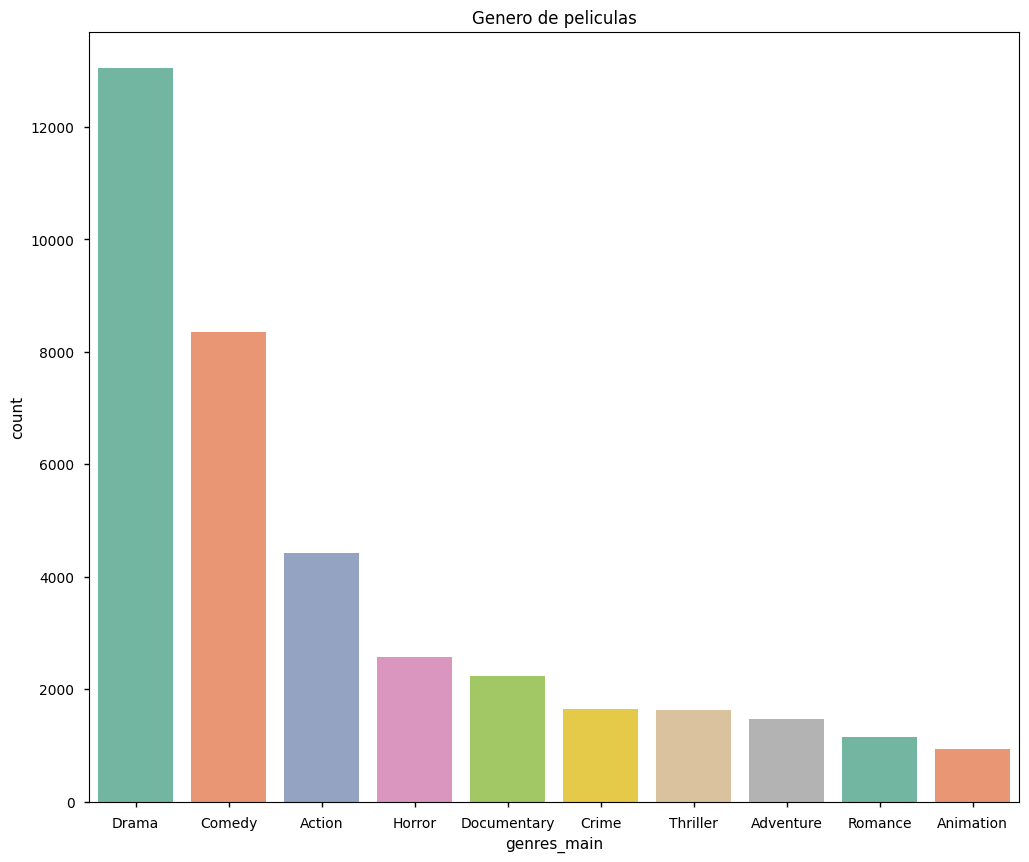

In [26]:
# Analisis de contenido por genero
plt.figure(figsize=(12,10))
sns.countplot(x='genres_main', data=df, palette='Set2', order=df['genres_main'].value_counts().index[0:10])
plt.title('Genero de peliculas')

Observamos que 'Drama' y 'Comedy', son los generos mas producidos

Text(0.5, 1.0, 'Tipo de contenido por Año')

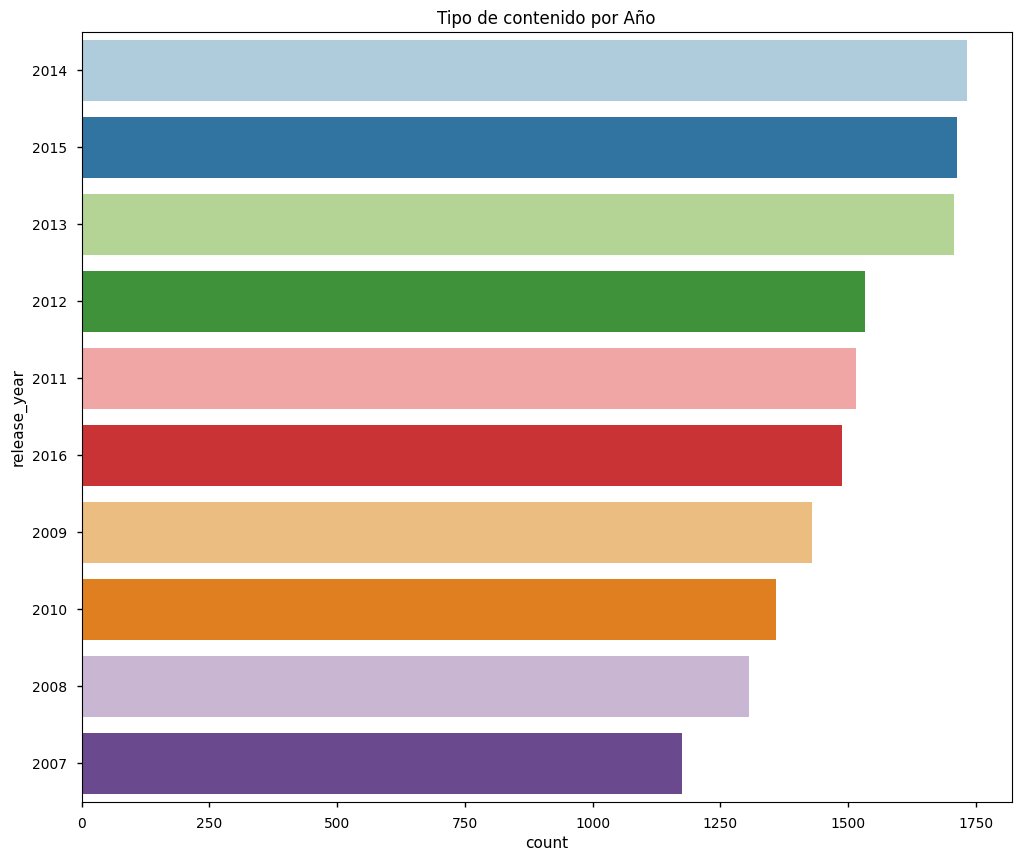

In [27]:
# Analisis de contenido por año
plt.figure(figsize=(12,10))
sns.countplot(y='release_year', data=df, palette='Paired', order=df['release_year'].value_counts().index[0:10])
plt.title('Tipo de contenido por Año')

Observamos que en el 2014 y 2015 son los años que han tenidos mas producciones.

Text(0.5, 1.0, 'Tipo de contenido por Mes')

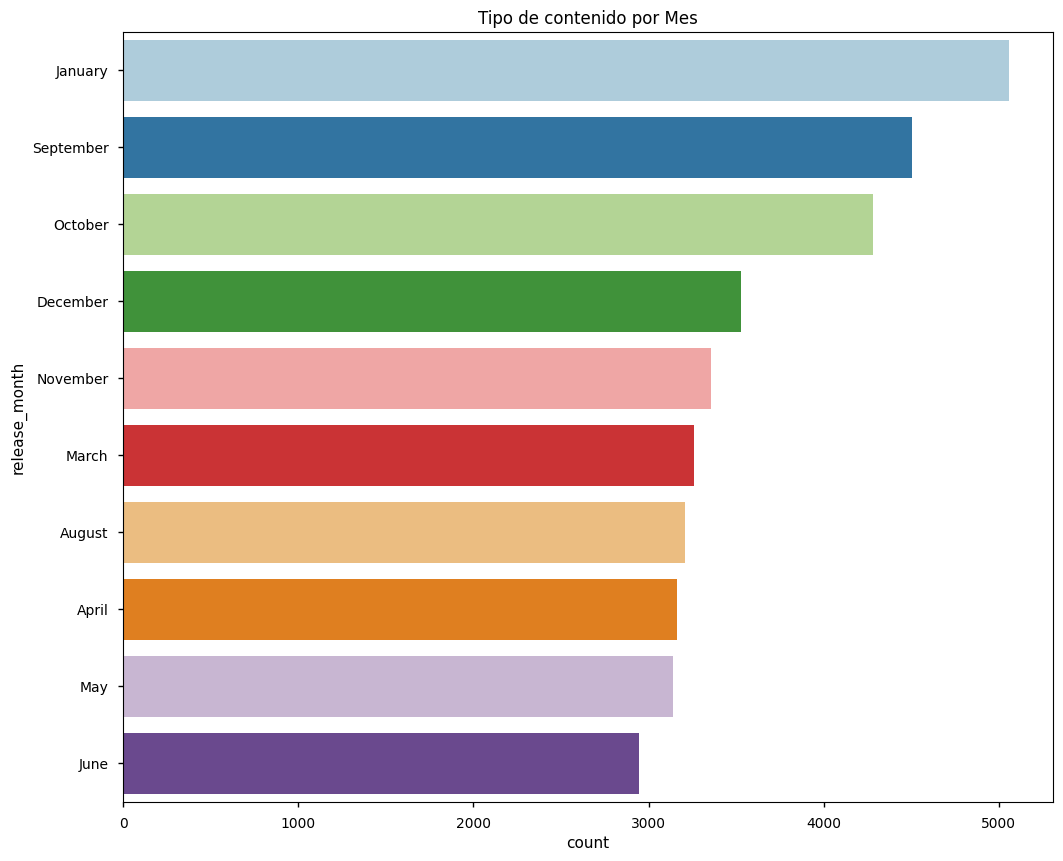

In [28]:
# Analisis de contenido por mes
plt.figure(figsize=(12,10))
sns.countplot(y='release_month', data=df, palette='Paired', order=df['release_month'].value_counts().index[0:10])
plt.title('Tipo de contenido por Mes')

Del grafico los meses con mas producciones son Enero y Setiembre

Text(0.5, 1.0, 'Tiempo de duracion de Peliculas')

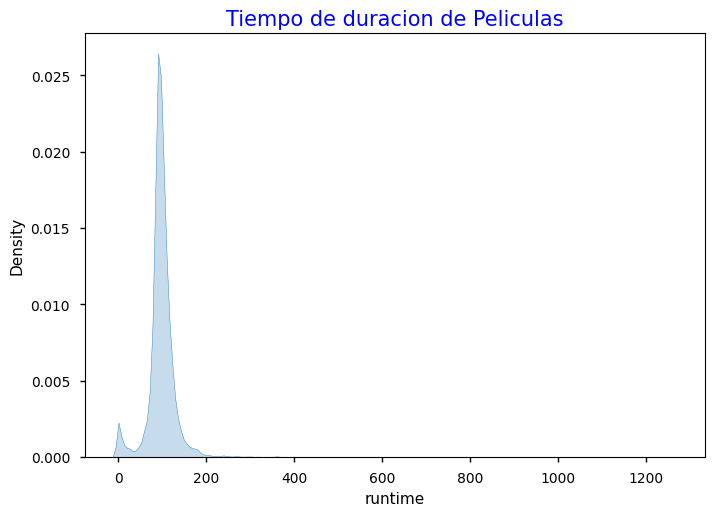

In [29]:
# Analisis de duracion de movies
sns.kdeplot(data=df['runtime'], shade=True)
plt.title('Tiempo de duracion de Peliculas', fontsize=15, color='blue')

Observamos que la mayor cantidad de producciones esta en 50 y 150 minutos

Text(0.5, 1.0, 'Ganancia recaudado por año')

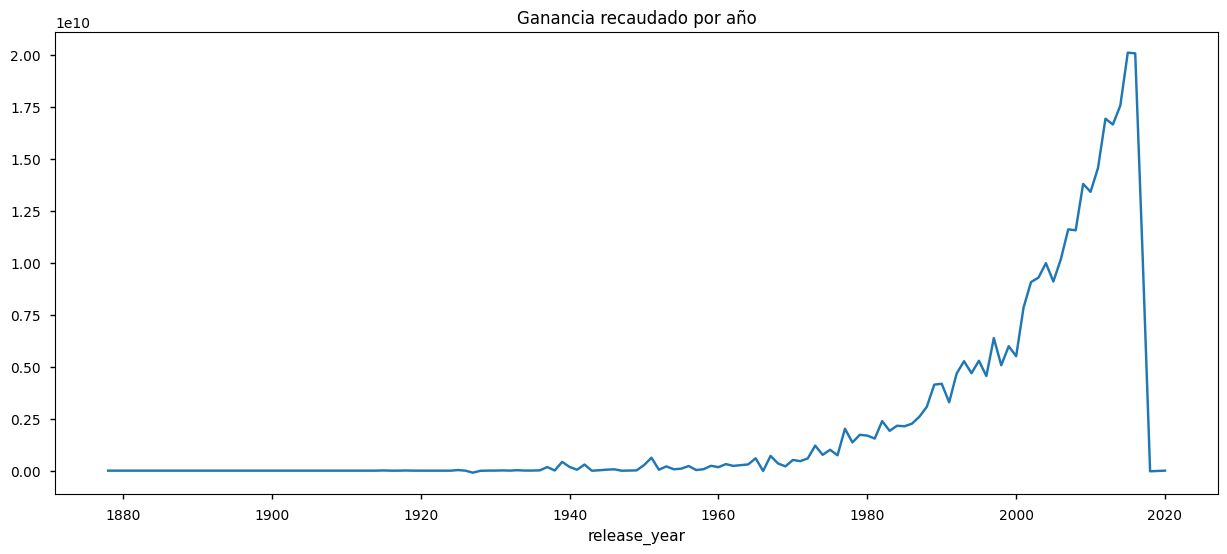

In [30]:
# Tendencia por año
release_year = df.groupby(['release_year']).sum()
release_year = release_year.sort_index()

plt.figure(figsize=(15,6))
sns.lineplot(x=release_year.index, y=release_year['revenue'].values - release_year['budget'].values)
plt.title('Ganancia recaudado por año')

Observamos que en el año 2018 fue pico en recaudacion, luego en 2019 y 2020 descendio por efecto del COVID

Text(0.5, 1.0, 'Ganancia recaudado por mes')

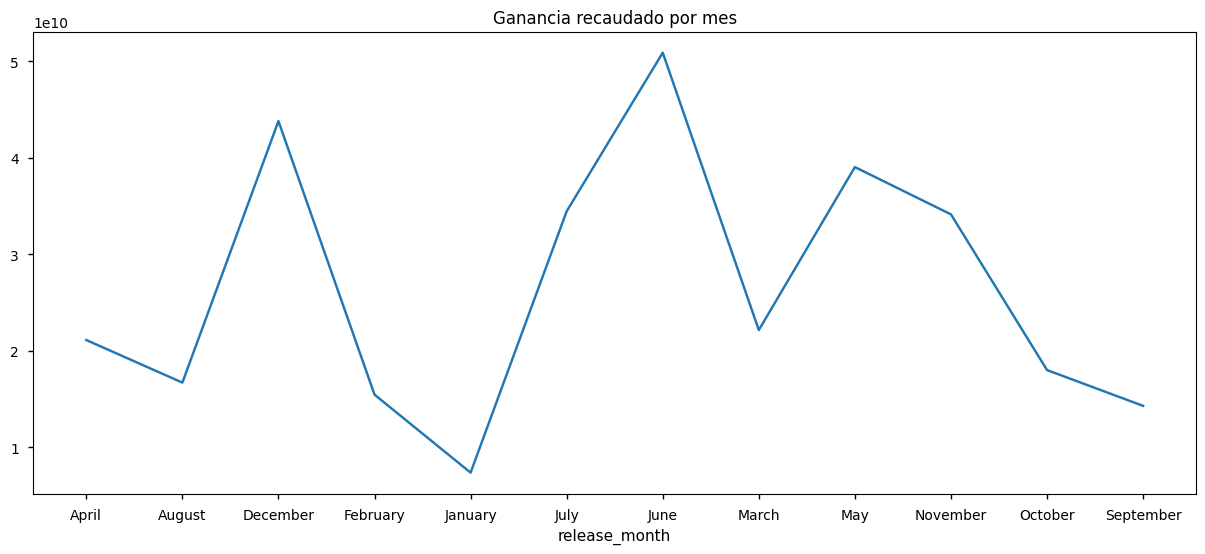

In [31]:
# Tendencia por mes
release_month = df.groupby(['release_month']).sum()
release_month = release_month.sort_index()

plt.figure(figsize=(15,6))
sns.lineplot(x=release_month.index, y=release_month['revenue'].values - release_month['budget'].values)
plt.title('Ganancia recaudado por mes')

Observamos en los meses de Junio, Diciembre y Mayor hubo mayor recaudacion

Text(0.5, 1.0, 'Paises que mas peliculas realizan')

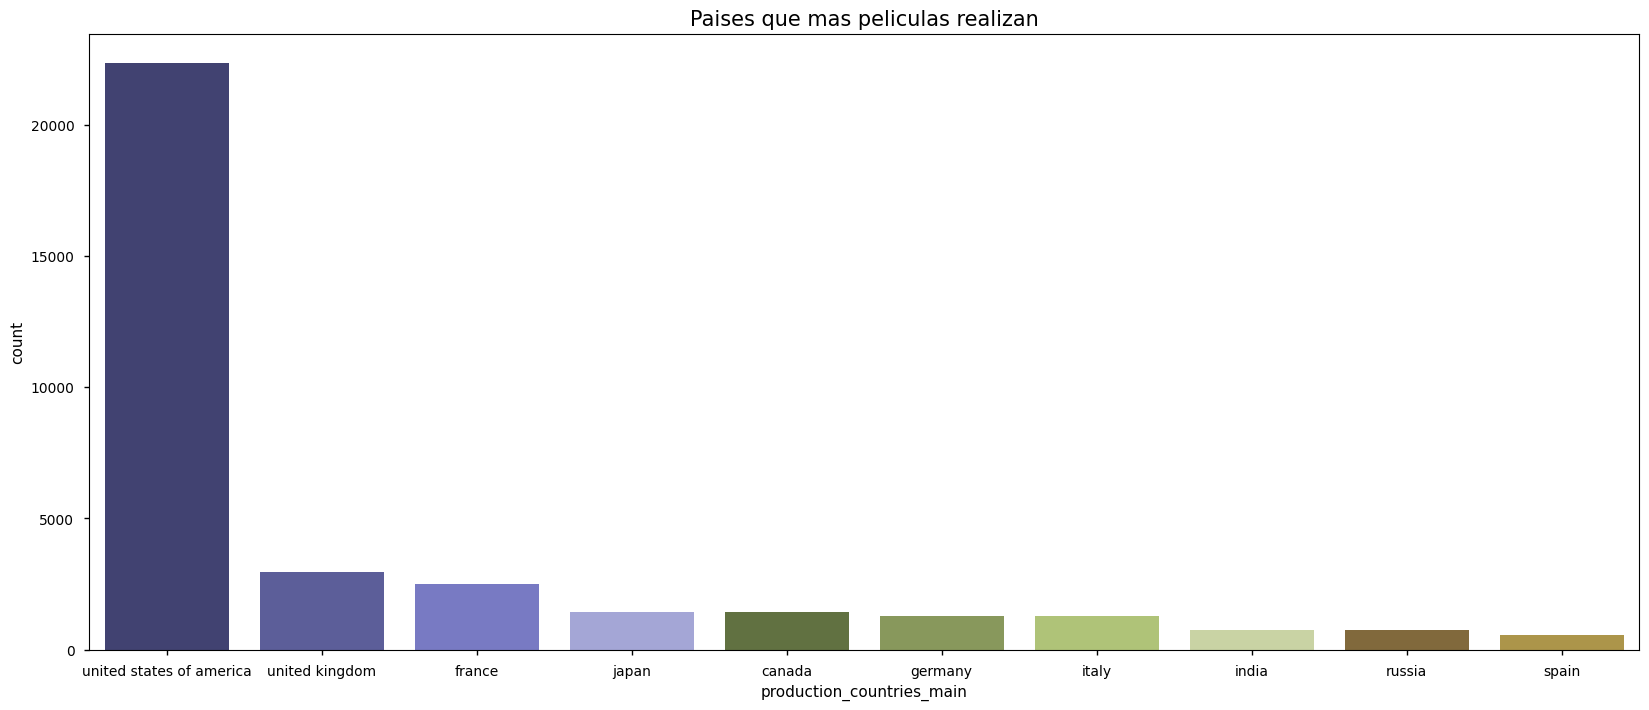

In [32]:
# Paises que mas peliculas realizan
plt.figure(figsize=(20,8))
sns.countplot(x='production_countries_main', data=df, palette='tab20b', order=df['production_countries_main'].value_counts().index[0:10])
plt.title('Paises que mas peliculas realizan', fontsize=15)

Los paises con mas produccion es USA, United Kingdom y France

Text(0.5, 0, 'Numero de peliculas lanzadas')

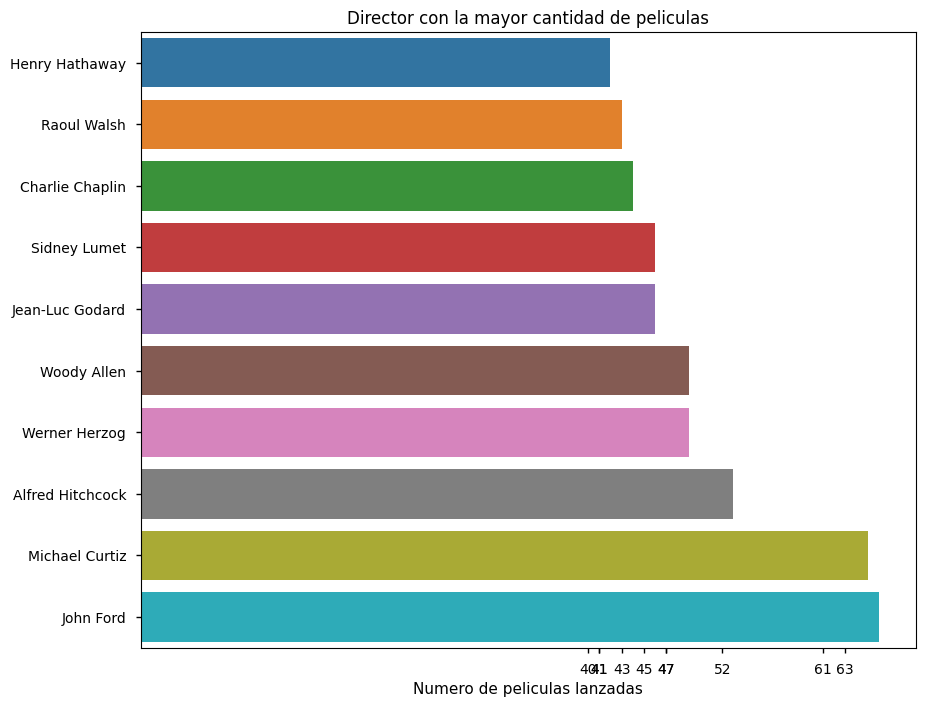

In [33]:
# Directores con mayor numero de peliculas producidas
plt.figure(figsize=(10,8))
sns.barplot(y=df['director_main'].value_counts()[:10].sort_values().index, x=df['director_main'].value_counts()[:10].sort_values().values)
plt.title('Director con la mayor cantidad de peliculas')
plt.xticks(df['director'].value_counts()[:10].sort_values().values)
plt.xlabel('Numero de peliculas lanzadas')

Los directores John Fory Y Michael Curtiz hicieron las mayor cantidad de producciones

Text(0.5, 0, 'Numero de peliculas lanzadas')

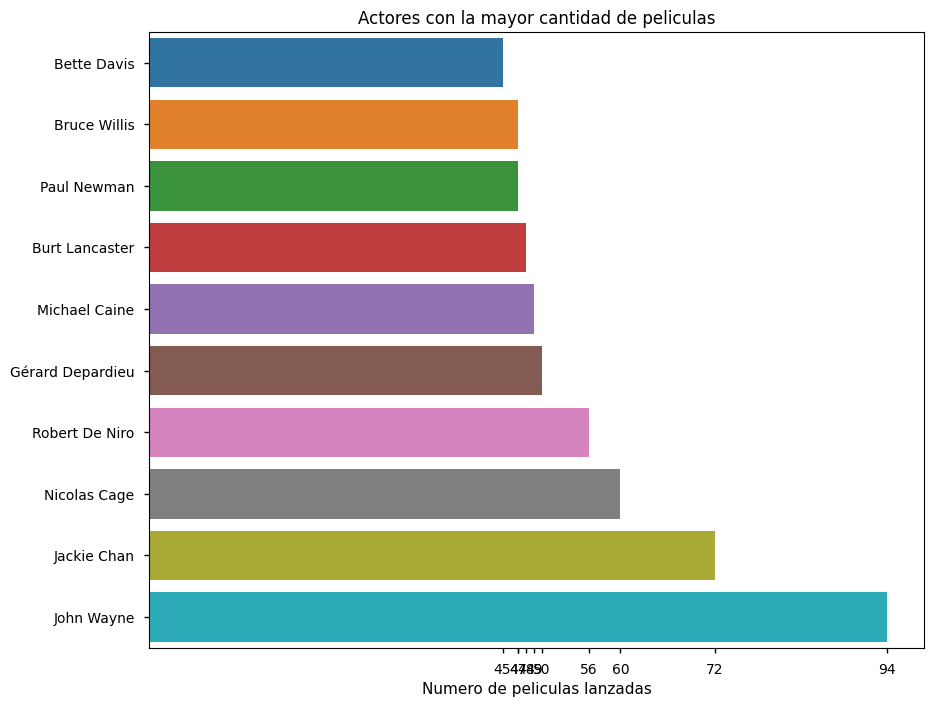

In [34]:
# Actores con mayor numero de peliculas producidas
plt.figure(figsize=(10,8))
sns.barplot(y=df['actor_main'].value_counts()[:10].sort_values().index, x=df['actor_main'].value_counts()[:10].sort_values().values)
plt.title('Actores con la mayor cantidad de peliculas')
plt.xticks(df['actor_main'].value_counts()[:10].sort_values().values)
plt.xlabel('Numero de peliculas lanzadas')

Los actores John Wayne y Jackie Chan son los han tenido mas producciones

# Sistema de Recomendacion

Contenido basado en filtro

Para este sistema de recomendacion, el contenido de la pelicula(reparto, descripcion, director, genero) se utiliza para encontrar similitud con otra peliculas.
Entonces se recomienda las peliculas que tienen mas probabilidadas de ser similares

In [35]:
# De las caracteristicas de genero, actor, director y overview
nro_registros = 5000
features = ['_genres', 'director', 'actor', 'overview', 'title']
df_ml = df[features].head(nro_registros)
df_ml = df_ml.dropna(how='any', subset=features)

In [36]:
# Limpiando la data
#!pip install nltk
import nltk
import re

# stopwords
# nltk.download('stopwords')

stemmer = nltk.SnowballStemmer("english")

from nltk.corpus import stopwords
import string

stopword = set(stopwords.words("english"))

# Definimos función de limpieza
def clean_data(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [37]:
for feature in features:
    if feature not in  ['title']:
        df_ml[feature] = df_ml[feature].apply(clean_data)

df_ml.head(2)

,_genres,director,actor,overview,title
0,anim comedi famili,john lasset,tom hank tim allen rickl jim varney wallac sha...,led woodi andi toy live happili room andi birt...,Toy Story
1,adventur fantasi famili,joe johnston,robin william jonathan hyde kirsten dunst brad...,sibl judi peter discov enchant board game open...,Jumanji


In [38]:
# Ahora podemos crear nuestra 'sopa de metadatos', que es una cadena que contiene
# todos los metadatos que queremos alimentar a nuestro vectorizador
def create_soup(x):
    return x['_genres'] + ' ' + x['director'] + ' ' + x['actor'] + ' ' + x['overview']

In [39]:
df_ml['soup'] = df_ml.apply(create_soup, axis=1)
df_ml['soup'][0]

'anim comedi famili john lasset tom hank tim allen rickl jim varney wallac shawn john ratzenberg anni pott john morri erik von detten lauri metcalf r lee ermey sarah freeman penn jillett led woodi andi toy live happili room andi birthday bring buzz lightyear onto scene afraid lose place andi heart woodi plot buzz circumst separ buzz woodi owner duo eventu learn put asid differ'

In [40]:
# Import CountVectorizer and create the cuount matrix
from sklearn. feature_extraction.text import CountVectorizer

count = CountVectorizer()
count_matrix = count.fit_transform(df_ml['soup'])

In [41]:
# Compute the cosine similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [42]:
# Restablece el indice de nuestro Dataframe principal y construyo el mapeo inverso como antes
df_ml = df_ml.reset_index()
indices = pd.Series(df_ml.index, index=df_ml['title'])

In [43]:
def get_recomentacion(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Obtengo las puntuaciones de similitud por pares de todas las peliculas con esa pelicula
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordene las peliculas segun las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obten las puntuaciones de las 5 peliculas mas similares
    sim_scores = sim_scores[1:6]

    # Obtenga los indices de las peliculas
    movie_indices = [i[0] for i in sim_scores]

    # Devuelve el top 10 de peliculas similares
    return df_ml['title'].iloc[movie_indices]

In [44]:
get_recomentacion('Born to Win')

1689    Kissing a Fool
2402                Go
4640          Intimacy
1645     Suicide Kings
2546       The Killing
Name: title, dtype: object